# Deconvolving the Mixing Matrix

The goal of this notebook is showcase different ways in which masking can be taken into account when performing 2-point statistics on partial sky maps.

We consider four different methods which we can classify along two axis:
- Is the effect forward modelled in the theory or removed in the data?
- Are we working in Fourier or real space?

The four methods are:
- **Forward method** (Fourier / Forward): In this method we multiply the theory full-sky $C_\ell$ by the mixing matrix.
- **Master method** (Fourier / Forward & Invert): In this method we first multiply the theory full-sky $C_\ell$ by the mixing matrix. Then, we bin the resulting $C_\ell$. Finally, we multiply by the binned inverse mixing matrix.
- **Direct inversion** (Fourier / Invert): In this method we multiply the data by the inverse mixing matrix and bin the resulting $C_\ell$.
- **Polspice**: (Real / Invert): In this method we transform the $C_\ell$ to real-space angular correlation functions and divide them by the mask angular correlation function. This step has to be done carefully to account for the mixing between E and B modes. Finally we transform back to $C_\ell$.


## Dependencies

In [1]:
import camb
import iolaus
import heracles
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from heracles.twopoint import mixing_matrices

## Make Catalog

In [2]:
nside = 32
npix = hp.nside2npix(nside)
ngals = 100*npix
print(f"npix = {npix}", f"ngals = {ngals}")

npix = 12288 ngals = 1228800


In [3]:
phis = np.random.uniform(0, 2 * np.pi, ngals)
cos_thetas = np.random.uniform(-0.9999, 0.9999, ngals)
thetas = np.arccos(cos_thetas)
# Go from HEALPix coordinates to indices
pixels = hp.ang2pix(nside, thetas, phis)
# Initate the map and fill it with the values
map = np.zeros(npix)
for i in range(ngals):
    map[pixels[i]] += 1
print("nbar: ", np.mean(map))
#map -= np.mean(map)

nbar:  100.0


In [4]:
theory_nside = 32*nside
theory_npix = hp.nside2npix(theory_nside)
print(f"theory_npix = {theory_npix}")
lmax = theory_nside
l = np.arange(lmax+1)
l2 = np.arange(2*lmax+1)
z = np.linspace(0, 3, 300)
pars = iolaus.get_pars()
z, nz = iolaus.get_nz(z)
z, bz = iolaus.get_bz(z)
sources = iolaus.get_sources(z, nz, bz)
theory_cls = iolaus.get_theory_cls(l2, pars, sources)
theory_map = iolaus.theory2map(theory_cls, theory_nside)

theory_npix = 12582912


In [5]:
theory_pixels = hp.ang2pix(theory_nside, thetas, phis)
Qs = theory_map[('SHE', 1)][0][theory_pixels]
Us = theory_map[('SHE', 1)][1][theory_pixels]

In [6]:
Q_map = np.zeros(npix)
U_map = np.zeros(npix)
for i in range(ngals):
    Q_map[pixels[i]] += Qs[i]
    U_map[pixels[i]] += Us[i]
Q_map /= map
U_map /= map

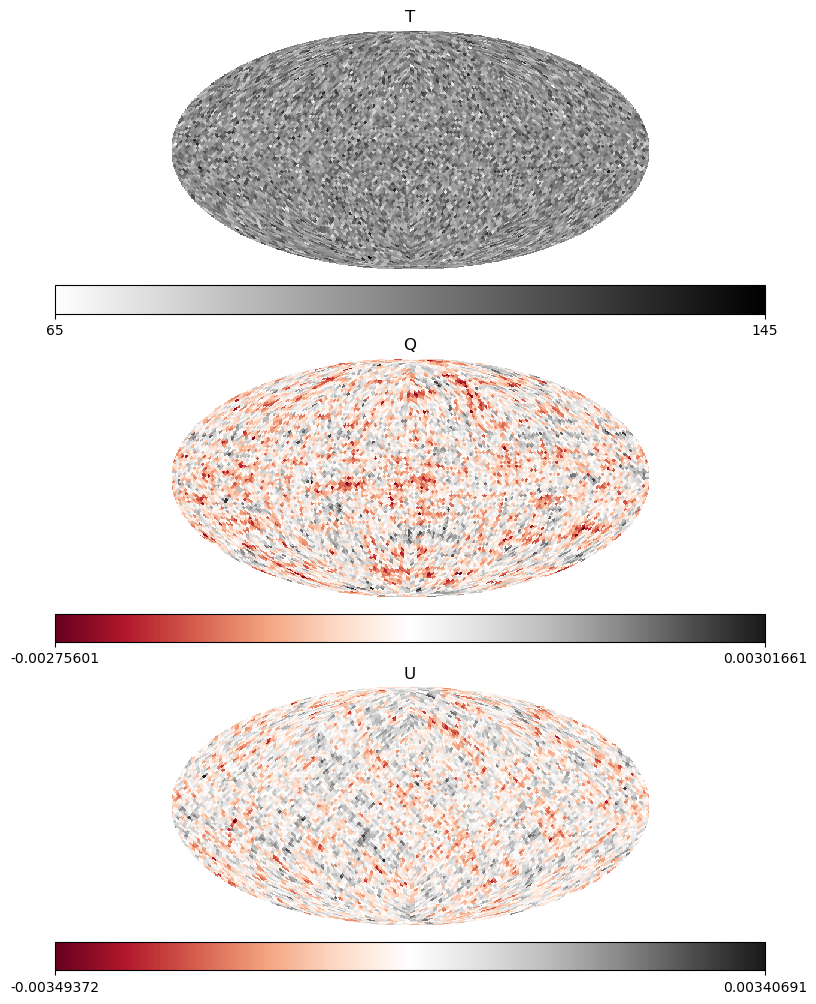

In [7]:
fig, ax = plt.subplots(3, figsize=(20, 10))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(map, cmap='binary', title='T', hold=True)
#hp.visufunc.projplot(thetas[:200], phis[:200], 'ro')
plt.sca(ax[1])
hp.mollview(Q_map, cmap='RdGy', title='Q', hold=True)
plt.sca(ax[2])
hp.mollview(U_map, cmap='RdGy', title='U', hold=True)
plt.show()

## Make data

In [8]:
nside = 128
lmax = nside
bin_num = 15
l = np.arange(lmax+1)
l2 = np.arange(2*lmax+1)

In [9]:
npix = hp.nside2npix(nside)
npix

196608

In [10]:
mask = iolaus.make_mask(nside, mode="patch")
mask_cls = iolaus.mask2cls(mask, 2*nside, 2*lmax)

In [11]:
z = np.linspace(0, 3, 300)
pars = iolaus.get_pars()
z, nz = iolaus.get_nz(z)
z, bz = iolaus.get_bz(z)
sources = iolaus.get_sources(z, nz, bz)
theory_cls = iolaus.get_theory_cls(l2, pars, sources)

In [12]:
theory_map = iolaus.theory2map(theory_cls, nside)
data_map = iolaus.apply_mask(theory_map, mask)
data_cls = iolaus.data2cls(data_map, nside, lmax)

In [13]:
list(data_cls.keys())

[('POS', 'POS', 1, 1), ('POS', 'SHE', 1, 1), ('SHE', 'SHE', 1, 1)]

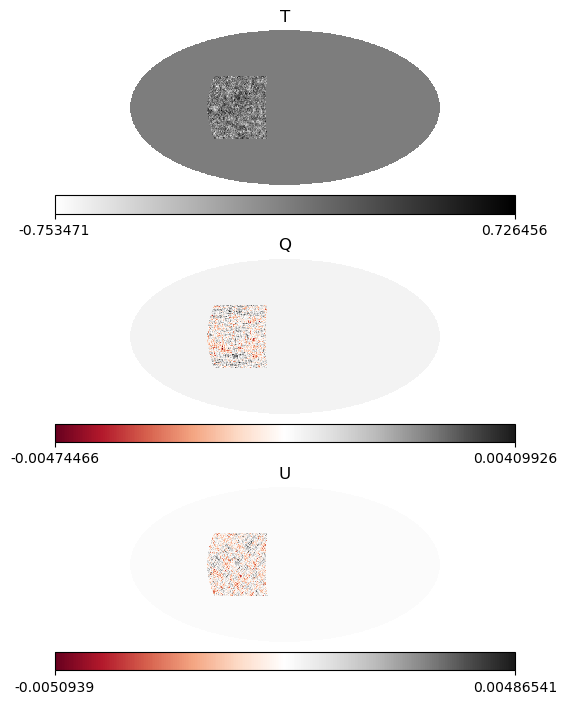

In [14]:
fig, ax = plt.subplots(3, figsize=(20, 7))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(data_map[('POS', 1)], cmap='binary', title='T', hold=True)
plt.sca(ax[1])
hp.mollview(data_map[('SHE', 1)][0], cmap='RdGy', title='Q', hold=True)
plt.sca(ax[2])
hp.mollview(data_map[('SHE', 1)][1], cmap='RdGy', title='U', hold=True)
plt.show()

### Binning

In [15]:
#bin_edges = np.logspace(np.log10(10), np.log10(lmax+1), bin_num+1).astype(int)
bin_edges = np.linspace(10, lmax+1, bin_num+1).astype(int)
B = np.diag(np.ones(lmax+1))
B = iolaus.bin2pt(B, bin_edges, 'B')
B = B['B']

n, m = B.shape
B2 = np.zeros((n, 2*lmax+1))
B2[:, :lmax+1] = B

In [16]:
# Binned ls
q = B @ l 

### Mixing Matrix

In [17]:
mapper = heracles.healpy.HealpixMapper(2*nside, 2*lmax)
fields_data = iolaus.make_fields(mapper, mode='data')
mms = mixing_matrices(fields_data, mask_cls,
    l3max=2*lmax+lmax, l2max=2*lmax, l1max=lmax)

In [18]:
#mms = {}
#mms[("POS", "POS", 1, 1)] = _mms[("POS", "POS", 1, 1)]
#mms[("POS", "G_E", 1, 1)] = _mms[("POS", "SHE", 1, 1)]
#mms[("G_E", "G_E", 1, 1)] = _mms[("SHE", "SHE", 1, 1)][0]
#mms[("G_B", "G_B", 1, 1)] = _mms[("SHE", "SHE", 1, 1)][1]
#mms[("G_E", "G_B", 1, 1)] = _mms[("SHE", "SHE", 1, 1)][2]

### Plotting

In [19]:
compsep_theory_cls = iolaus.compsep_cls(theory_cls)
compsep_data_cls = iolaus.compsep_cls(data_cls)

In [20]:
list(data_cls.keys())

[('POS', 'POS', 1, 1), ('POS', 'SHE', 1, 1), ('SHE', 'SHE', 1, 1)]

In [21]:
fields_a = fields_b = [('POS', 1), ('G_E', 1), ('G_B', 1)]

('POS', 'POS', 1, 1)
('POS', 'G_E', 1, 1)
('POS', 'G_B', 1, 1)
('G_E', 'POS', 1, 1)
('G_E', 'G_E', 1, 1)
('G_E', 'G_B', 1, 1)
('G_B', 'POS', 1, 1)
('G_B', 'G_E', 1, 1)
('G_B', 'G_B', 1, 1)


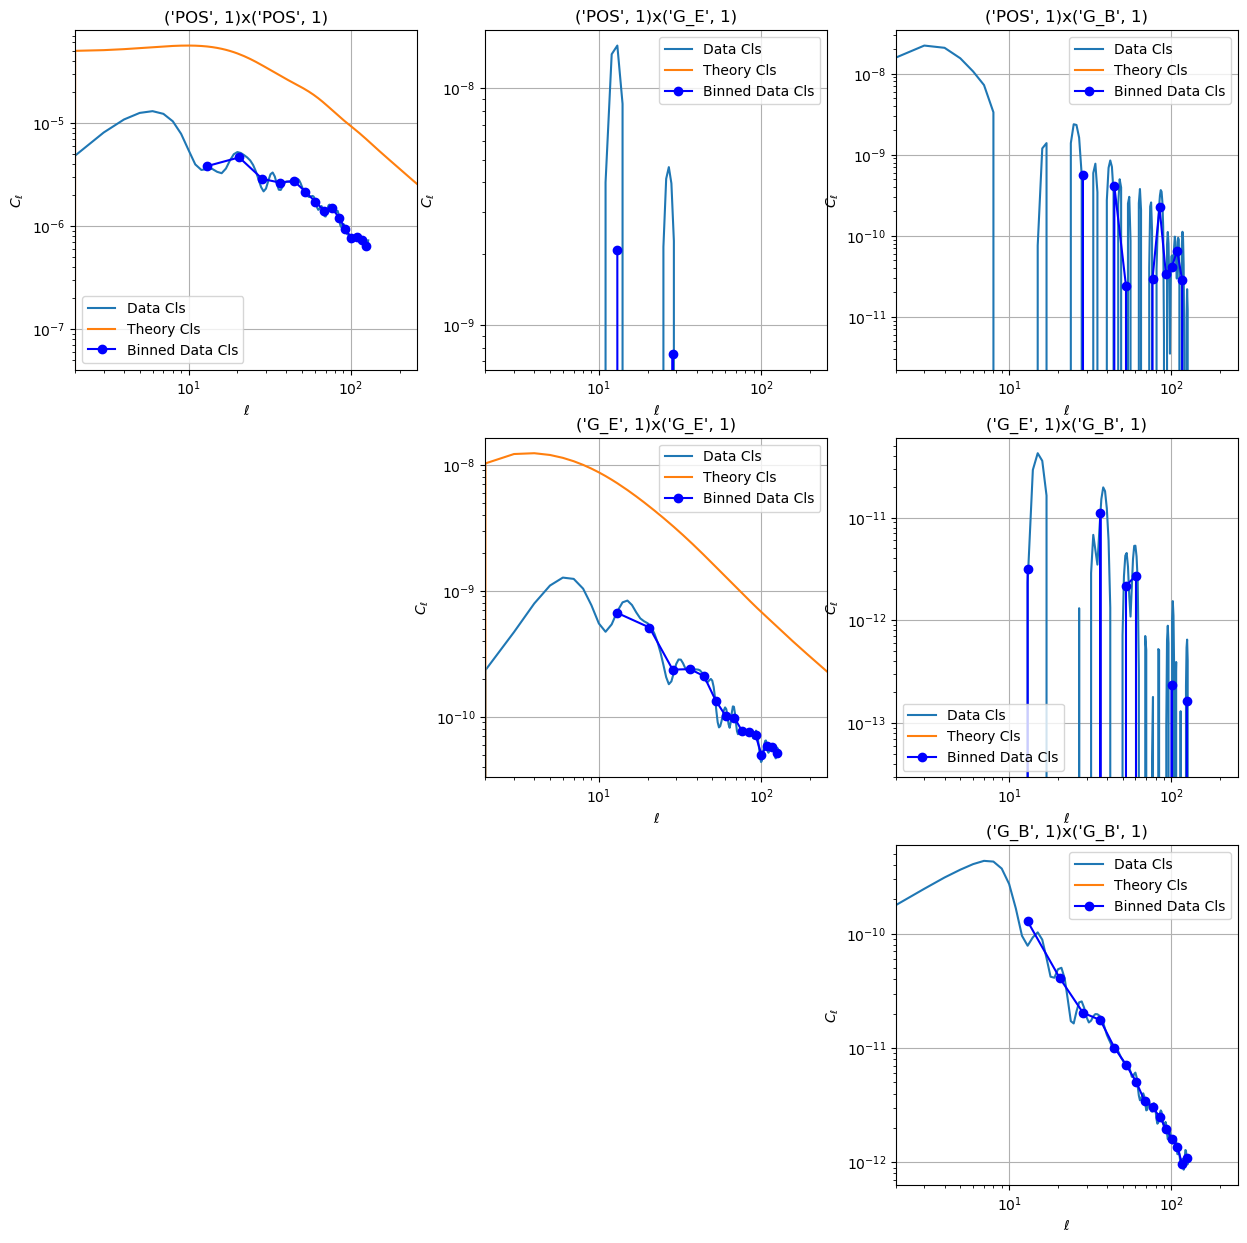

In [22]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1[0], s2[0], s1[1], s2[1])
        print(proposed_key)
        if i <= j: 
            t = compsep_theory_cls[proposed_key]
            d = compsep_data_cls[proposed_key]
            axis[i, j].plot(l,  d, label="Data Cls")
            axis[i, j].plot(l2, t, label="Theory Cls")
            axis[i, j].plot(q,  B @ d, "bo-", label="Binned Data Cls")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].set_xlim(2, 2*lmax)
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()

## Forward Model 

In Fourier space, we can relate an observed angular power spectrum $\tilde{C}_\ell$ to a theoretical full-sky angular power spectrum $C_\ell$ through the mixing matrix $M$, a matrix that contains the effect of the mask:
$$ \tilde{C}_\ell = M C_\ell $$

We find better results by considering a non-square square matrix such that the theory $C_\ell$'s are evaluated up to $2\ell_{max}$, where $\ell_{max}$ is the maximum multipole considered for the observed $\tilde{C}_\ell$.

We can modify the previous fudamental relation to express all Fourier space methods by considering a general matrix, A, such that:
$$ A \tilde{C}_\ell = A M C_\ell $$

Becuase we are often interested in the binned angular power spectrum, in the forward method $A = B$, where $B$ is the binning matrix.

To account for the E-B mixing, we compute the parial sky $C_\ell$  as:
$$ \tilde{C}_\ell^{EE} = B(M^{EE} C_\ell^{BB} + M^{BB} C_\ell^{EE}) \\
   \tilde{C}_\ell^{BB} = B(M^{EE} C_\ell^{EE} + M^{BB} C_\ell^{BB}) 
$$

Note that in our case $C_\ell^{BB} = 0$ by definition.

In [23]:
ft = iolaus.Forwards(theory_cls, mms, B)
compsep_ft = iolaus.compsep_cls(ft)

In [24]:
for key in list(compsep_ft.keys()):
    print(key, compsep_ft[key].shape)

('POS', 'POS', 1, 1) (15,)
('POS', 'G_E', 1, 1) (15,)
('POS', 'G_B', 1, 1) (15,)
('G_E', 'G_E', 1, 1) (15,)
('G_B', 'G_B', 1, 1) (15,)
('G_E', 'G_B', 1, 1) (15,)


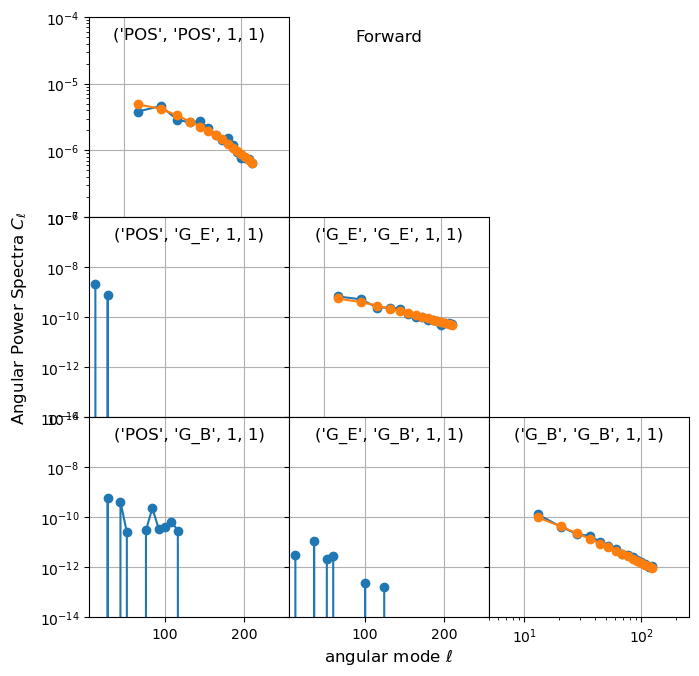

In [81]:
fig, axis = plt.subplots(3, 3, figsize=(3*2, 3*2))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1[0], s2[0], s1[1], s2[1])
        #print(proposed_key)
        #if i <= j: 
        if proposed_key in compsep_ft:
            t = compsep_ft[proposed_key]
            d = compsep_data_cls[proposed_key]
            axis[j, i].plot(q, B @ d, "o-", label="Data Cls")
            axis[j, i].plot(q, t, 'o-', label="Theory Cls")
            axis[i, i].set_xscale('log')
            axis[j, i].set_yscale('log')
            axis[j, i].set_title(f"{proposed_key}", y=0.85)
            axis[j, i].grid()
            axis[j, i].set_xlim(5, 2*lmax)
            if i == 0 and j == 0:
                axis[j, i].set_ylim(1e-7, 1e-4)
            else:
                axis[j, i].set_ylim(1e-14, 1e-6)
            if i>0:
                axis[j, i].set_yticklabels([])
        else:
            axis[j, i].axis('off')
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("Angular Power Spectra $C_\\ell$", x=-0.1, ha="right")
fig.suptitle("Forward")
plt.show()

## Master Model

Similarly, the master method is equivalent to considering $A = (B M B^T)^{-1} B$.
Since the the initial steps of computing the master method $C_\ell$'s are the same as the forward method we reuse the previously computed $C_\ell$'s. However, we still need to apply the inverse binning matrix to get the final $C_\ell$'s.
Because we originally considered a non-square mixing matrix, we first crop the mixing matrix to the size of the data $C_\ell$'s we then bin. This operation is done in one single operation by applying the matrix $B_2$. 

Since the mixing of the E and B modes is already accounted in the first step when multiplying by the mixing matrix, we do not need to consider the mixing when inverting the binned mixing matrix.

In [26]:
md, mt = iolaus.Master(data_cls, theory_cls, mms, B, B2)

In [27]:
compsep_md = iolaus.compsep_cls(md)
compsep_mt = iolaus.compsep_cls(mt)

('POS', 'POS', 1, 1)
('POS', 'G_E', 1, 1)
('POS', 'G_B', 1, 1)
('G_E', 'POS', 1, 1)
('G_E', 'G_E', 1, 1)
('G_E', 'G_B', 1, 1)
('G_B', 'POS', 1, 1)
('G_B', 'G_E', 1, 1)
('G_B', 'G_B', 1, 1)


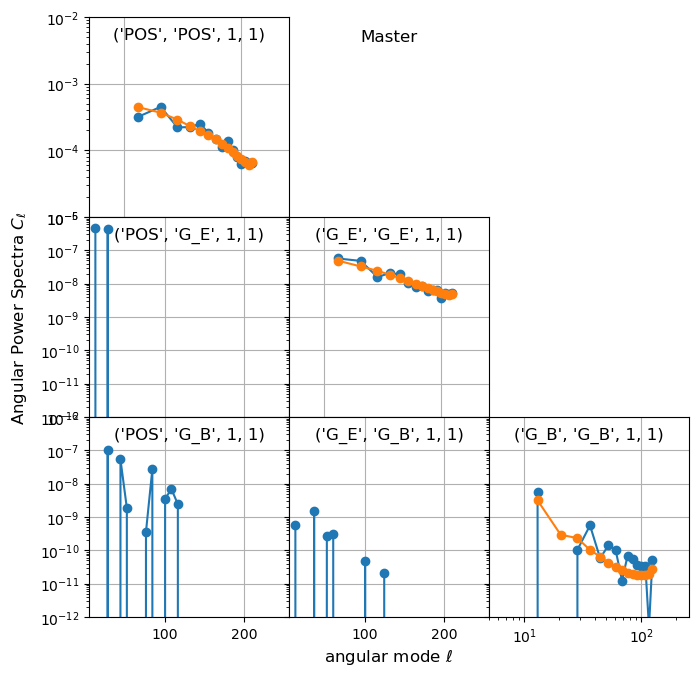

In [82]:
fig, axis = plt.subplots(3, 3, figsize=(3*2, 3*2))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1[0], s2[0], s1[1], s2[1])
        print(proposed_key)
        if i <= j: 
            t = compsep_mt[proposed_key]
            d = compsep_md[proposed_key]
            axis[j, i].plot(q, d, "o-", label="Data Cls")
            axis[j, i].plot(q, t, 'o-', label="Theory Cls")
            axis[i, i].set_xscale('log')
            axis[j, i].set_yscale('log')
            axis[j, i].set_title(f"{proposed_key}", y=0.85)
            axis[j, i].grid()
            axis[j, i].set_xlim(5, 2*lmax)
            if i == 0 and j == 0:
                axis[j, i].set_ylim(1e-5, 1e-2)
            else:
                axis[j, i].set_ylim(1e-12, 1e-6)
            if i>0:
                axis[j, i].set_yticklabels([])
        else:
            axis[j, i].axis('off')
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("Angular Power Spectra $C_\\ell$", x=-0.1, ha="right")
fig.suptitle("Master")
plt.show()

## Direct Inversion

The direct inversion method is equivalent to considering $A = B M^{-1}$.

To account for the E-B mixing, we compute the full sky $C_\ell^{E/B}$  as:
$$  \begin{bmatrix} 
 \langle C_l^{E\!E'} \rangle \\ \langle C_l^{B\!B'} \rangle  \end{bmatrix}
 =
\begin{bmatrix}
   M^{E\!E E'\!E'} & M^{B\!B E'\!E'} \\
   M^{E\!E B'\!B'} & M^{B\!B B'\!B'} 
\end{bmatrix}^{-1}
\begin{bmatrix} 
    \langle \tilde{C}_l^{E\!E'} \rangle \\ \langle \tilde{C}_l^{B\!B'} \rangle 
\end{bmatrix}
$$

In [29]:
id = iolaus.Inversion(data_cls, mms, B, B2)
compsep_id = iolaus.compsep_cls(id)

('POS', 'POS', 1, 1)
('POS', 'G_E', 1, 1)
('POS', 'G_B', 1, 1)
('G_E', 'POS', 1, 1)
('G_E', 'G_E', 1, 1)
('G_E', 'G_B', 1, 1)
('G_B', 'POS', 1, 1)
('G_B', 'G_E', 1, 1)
('G_B', 'G_B', 1, 1)


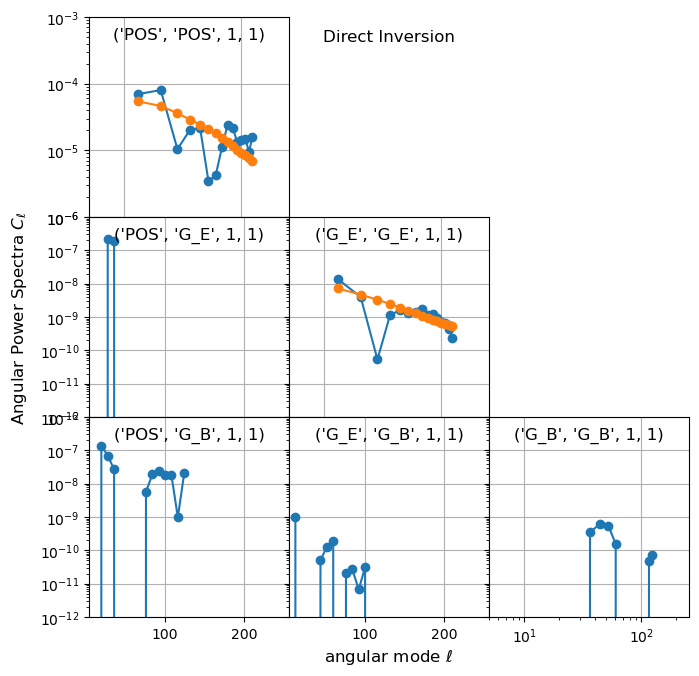

In [83]:
fig, axis = plt.subplots(3, 3, figsize=(3*2, 3*2))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1[0], s2[0], s1[1], s2[1])
        print(proposed_key)
        if i <= j: 
            t = B2 @ compsep_theory_cls[proposed_key]
            d = compsep_id[proposed_key]
            axis[j, i].plot(q, d, "o-", label="Data Cls")
            axis[j, i].plot(q, t, 'o-', label="Theory Cls")
            axis[i, i].set_xscale('log')
            axis[j, i].set_yscale('log')
            axis[j, i].set_title(f"{proposed_key}", y=0.85)
            axis[j, i].grid()
            axis[j, i].set_xlim(5, 2*lmax)
            if i == 0 and j == 0:
                axis[j, i].set_ylim(1e-6, 1e-3)
            else:
                axis[j, i].set_ylim(1e-12, 1e-6)
            if i>0:
                axis[j, i].set_yticklabels([])
        else:
            axis[j, i].axis('off')
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("Angular Power Spectra $C_\\ell$", x=-0.1, ha="right")
fig.suptitle("Direct Inversion")
plt.show()

## Polspice

In the Polspice method we account for the effect of the mask in real space. 
Let's start laying down some definitions. Given a complex field:
$$ \gamma(n) = (Q \pm i U)(n) = \sum_{l m} (E_{l m} \mp i B_{l m}) _{\mp 2} Y_{l m}(n)  $$
we can define the correlators:
$$ \xi_{+} = \langle \gamma^* \gamma\rangle  \hspace{6pt}\rm{and}\hspace{6pt} \xi_{-} = \langle \gamma \gamma \rangle $$
Then the associated parital sky correlatiors are given by:
$$ \xi_{\pm}(\theta) = \frac{\tilde{\xi}_{\pm}(\theta)}{\xi^{ww'}(\theta)} $$
which we can also express in terms of linear combinations of the measured $E$ and $B$ angular power spectra:
$$  \tilde{\xi}_{\pm}(\theta) = \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta) $$

The PolSpice method undoes the $E-B$ coupling by defining a correlator akin to $\xi_{+}(\theta)$ but with the Wigner matrix of a spin -2 field:
$$
\xi_{\rm dec}(\theta) = \frac{\tilde{\xi}_{\rm dec}(\theta)}{\xi^{ww'}(\theta)} = \nonumber \\ 
= \frac{1}{\xi^{ww'}(\theta)} \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l +  \tilde{C}^{BB}_l) d^l_{2 - 2}(\theta)
$$

Then one can construct a estimator for the full sky angular correlation functions by combining the correlation function and inverting the SWSH transform:
$$
C^{EE}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) + \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$
$$
C^{BB}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) - \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$

In [31]:
mask_cls = iolaus.mask2cls(mask, nside, lmax)
dnp = iolaus.Naive_Polspice(data_cls, mask_cls, B, patch_hole=True)
compsep_dnp = iolaus.compsep_cls(dnp)

Patching holes
Patching holes
Patching holes


('POS', 'POS', 1, 1)
('POS', 'G_E', 1, 1)
('POS', 'G_B', 1, 1)
('G_E', 'POS', 1, 1)
('G_E', 'G_E', 1, 1)
('G_E', 'G_B', 1, 1)
('G_B', 'POS', 1, 1)
('G_B', 'G_E', 1, 1)
('G_B', 'G_B', 1, 1)


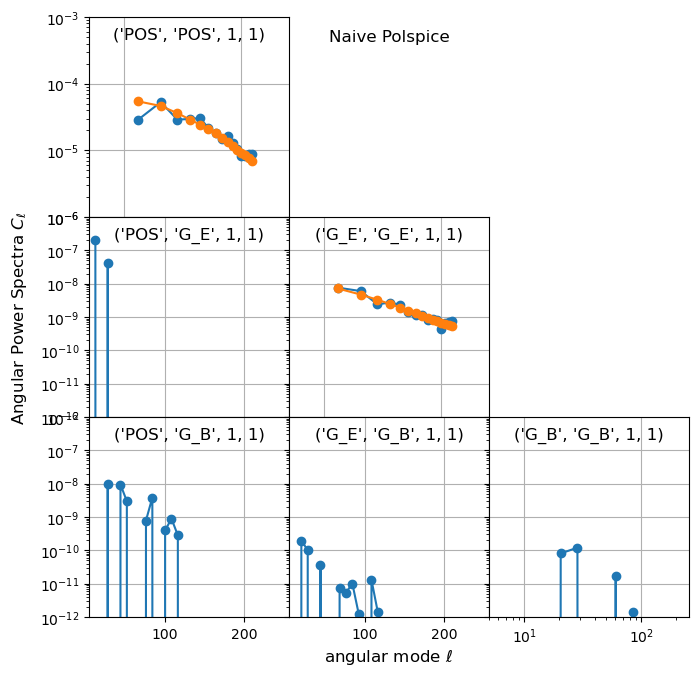

In [84]:
fig, axis = plt.subplots(3, 3, figsize=(3*2, 3*2))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1[0], s2[0], s1[1], s2[1])
        print(proposed_key)
        if i <= j: 
            t = compsep_theory_cls[proposed_key]
            d = compsep_dnp[proposed_key]
            axis[j, i].plot(q, d, "o-", label="Data Cls")
            axis[j, i].plot(q, B2 @ t, 'o-', label="Theory Cls")
            axis[i, i].set_xscale('log')
            axis[j, i].set_yscale('log')
            axis[j, i].set_title(f"{proposed_key}", y=0.85)
            axis[j, i].grid()
            axis[j, i].set_xlim(5, 2*lmax)
            if i == 0 and j == 0:
                axis[j, i].set_ylim(1e-6, 1e-3)
            else:
                axis[j, i].set_ylim(1e-12, 1e-6)
            if i>0:
                axis[j, i].set_yticklabels([])
        else:
            axis[j, i].axis('off')
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("Angular Power Spectra $C_\\ell$", x=-0.1, ha="right")
fig.suptitle("Naive Polspice")

plt.show()